# 1. 데이터 불러오기

In [102]:
import pandas as pd
import numpy as np

In [103]:
import warnings
warnings.filterwarnings('ignore')

In [104]:
df = pd.read_csv('train_전처리_0909_without_current.csv')
df_test = pd.read_csv('test_전처리_0909_without_current.csv')

### raw data 보관

In [105]:
raw = df_test
raw_train = df

### 불필요 변수 삭제

In [106]:
df = df.drop(columns = 'int_rate')
df_test = df_test.drop(columns = 'int_rate')

In [107]:
df = df.drop(columns = 'spline_segment_1')
df_test = df_test.drop(columns = 'spline_segment_1')

# 2. 전처리 (log transformation / 이상치 조정 / StandardScaler)

### (1) 이상치 조정

z-score 절대값이 3 초과인 경우는 3으로 고정

In [108]:
import numpy as np
from scipy import stats

# Z-score를 계산하고 임계값으로 클리핑하는 함수
def calculate_mean_std(df):
    """주어진 데이터프레임의 각 열에 대해 평균과 표준편차를 계산"""
    means = df.mean()
    stds = df.std()
    return means, stds

def clip_outliers_zscore(df, means, stds, threshold=3):
    df_clipped = df.copy()  # 원본 데이터를 유지하기 위해 복사
    for column in df_clipped.select_dtypes(include=[float, int]).columns:
        z_scores = stats.zscore(df_clipped[column])
        
        # Z-score가 threshold를 초과하는 값을 클리핑
        df_clipped[column] = np.where(z_scores > threshold, 
                                      means[column] + threshold * stds[column],
                                      df_clipped[column])
        
        # Z-score가 -threshold 미만인 값을 클리핑
        df_clipped[column] = np.where(z_scores < -threshold, 
                                      means[column] - threshold * stds[column],
                                      df_clipped[column])
    
    return df_clipped

# df에서 평균과 표준편차 계산
means, stds = calculate_mean_std(df)



In [109]:
# df에서 클리핑 적용
df_clipped = clip_outliers_zscore(df, means, stds, threshold=3)

# df_test에서 클리핑 적용 (동일한 평균과 표준편차 사용)
#df_test_clipped = clip_outliers_zscore(df_test, means, stds, threshold=3)


In [110]:
df_test_clipped = df_test

### (2) 왜도 보완 (log transformation)

왜도가 1 초과인 경우는 로그변환, -1 미만인 경우는 reverse + 로그변환

In [111]:
df = df_clipped
df_test = df_test_clipped

In [112]:
import numpy as np
import pandas as pd

# 제외할 열
exclude_columns = ['irr', 'total_pymnt', 'target']

# 수치형 변수 선택 및 제외할 열 제거
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns = numeric_columns.difference(exclude_columns)

# 변환 함수 정의
def apply_transformations(df):
    for col in numeric_columns:
        skewness = df[col].skew()
        print(f'{col}의 왜도: {skewness:.2f}')
        
        if (df[col] < 0).any():
            print(f'{col}는 0 미만의 값을 가집니다 (having negative value).')
        
        if skewness > 1:  # Right skewed
            # 로그 변환 적용 (양수 값만)
            if (df[col] <= 0).any():
                df[col] = np.log1p(df[col] - df[col].min() + 1)
                print(f'{col}에 로그 변환을 적용했습니다 (Shifted).')
            else:
                df[col] = np.log1p(df[col])
                print(f'{col}에 로그 변환을 적용했습니다.')
        
        elif skewness < -1:  # Left skewed
            # Reverse 변환 후 로그 변환 적용
            df[col] = np.log1p(df[col].max() - df[col])
            print(f'{col}에 Reverse-로그 변환을 적용했습니다.')
        
        # 처리 완료 후 구분선 출력
        print('----------')



In [113]:
# 원본 데이터프레임에 변환 적용
apply_transformations(df)

# 테스트 데이터프레임에도 동일한 변환 적용
apply_transformations(df_test)


all_util의 왜도: -0.25
----------
annual_inc의 왜도: 3.09
annual_inc에 로그 변환을 적용했습니다.
----------
chargeoff_within_12_mths의 왜도: 11.04
chargeoff_within_12_mths에 로그 변환을 적용했습니다 (Shifted).
----------
collections_12_mths_ex_med의 왜도: 7.61
collections_12_mths_ex_med에 로그 변환을 적용했습니다 (Shifted).
----------
covid_impact의 왜도: 0.54
----------
delinq_2yrs의 왜도: 2.59
delinq_2yrs에 로그 변환을 적용했습니다 (Shifted).
----------
delinq_amnt의 왜도: 30.56
delinq_amnt에 로그 변환을 적용했습니다 (Shifted).
----------
dti의 왜도: 0.23
----------
emp_title의 왜도: -0.68
emp_title는 0 미만의 값을 가집니다 (having negative value).
----------
fico_range_low의 왜도: 1.10
fico_range_low에 로그 변환을 적용했습니다.
----------
funded_amnt의 왜도: 0.81
----------
grade의 왜도: 0.59
----------
inq_last_6mths의 왜도: 1.40
inq_last_6mths에 로그 변환을 적용했습니다 (Shifted).
----------
num_actv_rev_tl의 왜도: 1.02
num_actv_rev_tl에 로그 변환을 적용했습니다 (Shifted).
----------
pub_rec_bankruptcies의 왜도: 2.31
pub_rec_bankruptcies에 로그 변환을 적용했습니다 (Shifted).
----------
spline_segment_2의 왜도: 0.94
----------
spline_segment_3의

### (3) 스케일링 (standardscaler)

In [114]:
from sklearn.preprocessing import StandardScaler

# 숫자형 변수 중 'target'과 'irr' 변수를 제외한 컬럼 선택
numeric_columns = df_clipped.select_dtypes(include=['float64', 'int64']).columns
numeric_columns = numeric_columns.drop(['target', 'irr', 'total_pymnt'])

# StandardScaler 객체 생성
scaler = StandardScaler()

# df_clipped의 숫자형 변수에 대해 fit 및 transform 적용
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# df_test_clipped의 숫자형 변수에 대해 transform 적용 (fit은 하지 않음)
df_test[numeric_columns] = scaler.transform(df_test[numeric_columns])

# 3. 회귀가정 확인

In [115]:
#df = df_clipped

In [116]:
#df_test = df_test_clipped

In [117]:
# 데이터프레임 내의 모든 bool 타입 컬럼을 0과 1로 변환
df.loc[:, df.select_dtypes(include='bool').columns] = df.select_dtypes(include='bool').astype(int)

In [118]:
df_test.loc[:, df_test.select_dtypes(include='bool').columns] = df_test.select_dtypes(include='bool').astype(int)

### 더미변수설정

base 변수:
1. verification_status: verified
2. purpose_debt: consolidation
3. home_ownership: Mortgage

In [119]:
columns_to_drop = ['verification_status_Verified', 'purpose_debt_consolidation', 'home_ownership_MORTGAGE']

df = df.drop(columns = columns_to_drop)
df_test = df_test.drop(columns = columns_to_drop)
raw = raw.drop(columns = columns_to_drop) # 원본 데이터도 동일하게 관리

### grade와 sub_grade의 높은 상관성으로 grade 제외

In [120]:
df = df.drop(columns = 'grade')
df_test = df_test.drop(columns = 'grade')
raw = raw.drop(columns = 'grade')
raw_train = raw_train.drop(columns = 'grade')

# 선형회귀 시도

In [121]:
import statsmodels.api as sm

# 독립 변수 X에 'total_pymnt', 'irr', 'target'을 제외한 나머지 변수들 선택
X = df.drop(columns=['total_pymnt', 'irr', 'target'])

# 종속 변수 y 설정
y = df['target']

# 상수항 추가 (절편을 포함하기 위해)
X = sm.add_constant(X)

# 회귀 모델 적합
model = sm.OLS(y, X)
results = model.fit()

# 모델 요약 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     1069.
Date:                Wed, 11 Sep 2024   Prob (F-statistic):               0.00
Time:                        14:07:08   Log-Likelihood:            -5.2293e+06
No. Observations:             1076079   AIC:                         1.046e+07
Df Residuals:                 1076035   BIC:                         1.046e+07
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

#### test

In [122]:
import statsmodels.api as sm

# 새로운 데이터프레임에 대한 전처리 (학습 데이터와 동일한 전처리 적용)
# new_df = ...  # 새 데이터 로드 또는 생성
new_X = df_test.drop(columns=['total_pymnt', 'irr', 'target'])  # 타겟 변수 및 불필요한 변수 제거
new_y = df_test['target']

# 상수항 추가 (절편 포함)
new_X = sm.add_constant(new_X)

# 학습된 모델을 이용해 예측 수행
new_predictions = results.predict(new_X)

# 예측 결과와 실제 값을 비교하는 데이터프레임 생성
comparison_df = pd.DataFrame({
    'Actual': new_y,                  # 실제 값
    'Predicted': new_predictions,     # 예측 값
    'Difference': new_y - new_predictions  # 실제 값과 예측 값의 차이
})

comparison_df

,Actual,Predicted,Difference
0,16.798714,-11.495662,28.294377
1,13.978714,0.148605,13.830109
2,7.818714,1.795714,6.023001
3,19.938714,0.497246,19.441468
4,9.998714,5.782359,4.216355
...,...,...,...
722735,16.564750,-7.082593,23.647343
722736,23.454750,-12.173133,35.627883
722737,30.964750,-14.020597,44.985347
722738,11.694750,-7.638344,19.333094


## 다중공선성

In [71]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF 데이터프레임 생성
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# VIF 점수 출력
print(vif_data)

                                feature       VIF
0                                 const  6.328134
1                       num_actv_rev_tl  1.257779
2                                   dti  1.261103
3                        fico_range_low  1.974667
4                           funded_amnt  1.802004
5                             emp_title  1.053970
6                            annual_inc  1.715259
7      verification_status_Not Verified  1.663864
8   verification_status_Source Verified  1.513597
9                           purpose_car  1.018516
10                  purpose_credit_card  1.122472
11                  purpose_educational  1.001770
12             purpose_home_improvement  1.096475
13                        purpose_house  1.011932
14               purpose_major_purchase  1.032172
15                      purpose_medical  1.020080
16                       purpose_moving  1.020125
17                        purpose_other  1.090872
18             purpose_renewable_energy  1.001492


In [125]:
from sklearn.metrics import confusion_matrix, classification_report

# 양수는 1, 음수는 0으로 변환
comparison_df['Actual_Binary'] = comparison_df['Actual'].apply(lambda x: 1 if x > 0 else 0)
comparison_df['Predicted_Binary'] = comparison_df['Predicted'].apply(lambda x: 1 if x > 0 else 0)

# 일치 여부 확인 (True if matching, False otherwise)
comparison_df['Match'] = comparison_df['Actual_Binary'] == comparison_df['Predicted_Binary']

# 혼동 행렬 생성
cm = confusion_matrix(comparison_df['Actual_Binary'], comparison_df['Predicted_Binary'])
print('Confusion Matrix:\n', cm)

# 분류 지표 생성
report = classification_report(comparison_df['Actual_Binary'], comparison_df['Predicted_Binary'])
print('\nClassification Report:\n', report)


Confusion Matrix:
 [[ 93511  34674]
 [291113 303442]]

Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.73      0.36    128185
           1       0.90      0.51      0.65    594555

    accuracy                           0.55    722740
   macro avg       0.57      0.62      0.51    722740
weighted avg       0.78      0.55      0.60    722740



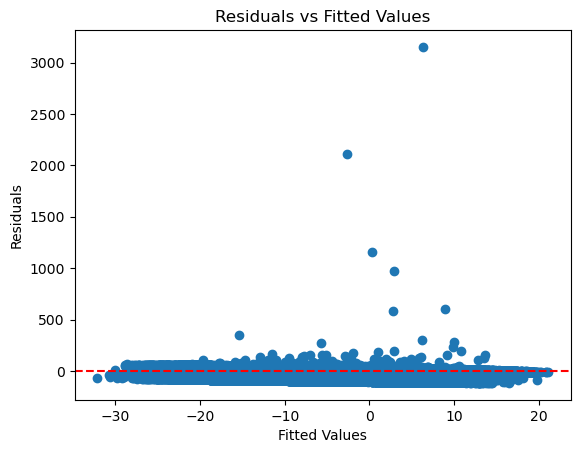

In [128]:
import matplotlib.pyplot as plt

# 잔차 vs 예측값 플롯
plt.scatter(results.fittedvalues, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()


##### 이상치 제거

In [129]:
# 잔차가 250 이상인 데이터포인트의 인덱스를 찾음
high_residuals_index = residuals[residuals.abs() >= 250].index

# 해당 인덱스의 데이터포인트 제거
df = df.drop(index=high_residuals_index)

# 결과 확인
print(f"제거된 데이터포인트의 인덱스: {high_residuals_index}")


제거된 데이터포인트의 인덱스: Index([400104, 443429, 496576, 586241, 789970, 845029, 845101, 863079, 906116,
       1005184],
      dtype='int64')


In [130]:
raw_train = raw_train.drop(index = high_residuals_index)

# 모델1. 선형회귀 통한 분류


In [84]:
# 독립 변수 X에 'total_pymnt', 'irr', 'target'을 제외한 나머지 변수들 선택
X = df.drop(columns=['total_pymnt', 'irr', 'target'])

# 종속 변수 y 설정
y = df['target']

# 상수항 추가 (절편을 포함하기 위해)
X = sm.add_constant(X)

# 회귀 모델 적합
model = sm.OLS(y, X)
results = model.fit()

# 모델 요약 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     1086.
Date:                Wed, 11 Sep 2024   Prob (F-statistic):               0.00
Time:                        08:37:43   Log-Likelihood:            -5.2201e+06
No. Observations:             1076069   AIC:                         1.044e+07
Df Residuals:                 1076025   BIC:                         1.044e+07
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

In [85]:
# 독립 변수 X에 'total_pymnt', 'irr', 'target'을 제외한 나머지 변수들 선택
new_X = df_test.drop(columns=['total_pymnt', 'irr', 'target'])

# 종속 변수 y 설정
new_y = df_test['target']

# 상수항 추가 (절편을 포함하기 위해)
new_X = sm.add_constant(new_X)


# 학습된 모델을 이용해 예측 수행
new_predictions = results.predict(new_X)

# 예측 결과와 실제 값을 비교하는 데이터프레임 생성
comparison_df = pd.DataFrame({
    'Actual': new_y,                  # 실제 값
    'Predicted': new_predictions,     # 예측 값
    'Difference': new_y - new_predictions  # 실제 값과 예측 값의 차이
})

comparison_df

,Actual,Predicted,Difference
0,16.798714,-11.438486,28.237200
1,13.978714,0.166386,13.812328
2,7.818714,1.830258,5.988456
3,19.938714,0.474721,19.463993
4,9.998714,5.771535,4.227179
...,...,...,...
722735,16.564750,-7.085819,23.650569
722736,23.454750,-12.173722,35.628472
722737,30.964750,-13.936702,44.901452
722738,11.694750,-7.607652,19.302402


In [86]:
from sklearn.metrics import confusion_matrix, classification_report

# 양수는 1, 음수는 0으로 변환
comparison_df['Actual_Binary'] = comparison_df['Actual'].apply(lambda x: 1 if x > 0 else 0)
comparison_df['Predicted_Binary'] = comparison_df['Predicted'].apply(lambda x: 1 if x > 0 else 0)

# 일치 여부 확인 (True if matching, False otherwise)
comparison_df['Match'] = comparison_df['Actual_Binary'] == comparison_df['Predicted_Binary']

# 혼동 행렬 생성
cm = confusion_matrix(comparison_df['Actual_Binary'], comparison_df['Predicted_Binary'])
print('Confusion Matrix:\n', cm)

# 분류 지표 생성
report = classification_report(comparison_df['Actual_Binary'], comparison_df['Predicted_Binary'])
print('\nClassification Report:\n', report)


Confusion Matrix:
 [[ 93570  34615]
 [291323 303232]]

Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.73      0.36    128185
           1       0.90      0.51      0.65    594555

    accuracy                           0.55    722740
   macro avg       0.57      0.62      0.51    722740
weighted avg       0.78      0.55      0.60    722740



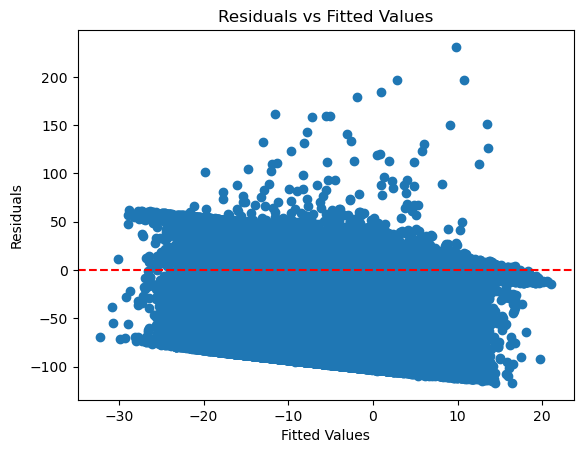

In [87]:
import matplotlib.pyplot as plt

residuals = results.resid

# 잔차 vs 예측값 plot
plt.scatter(results.fittedvalues, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# 로지스틱 회귀 + L1 Regulation 적용

In [139]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 종속 변수 y 설정 (0 이하인 경우 0, 0 초과인 경우 1로 변환)
y = (df['target'] > 0).astype(int)

# 독립 변수 설정 및 상수항 추가
X = df.drop(columns=['total_pymnt', 'irr', 'target'])
X = sm.add_constant(X)

# Train-Validation Split (9:1) with indices
X_train, X_val, y_train, y_val, train_idx, val_idx = train_test_split(
    X, y, X.index, test_size=0.1, random_state=42, stratify=y)

# raw_train에서 원본 데이터를 인덱스를 통해 분할
original_train = raw_train.loc[train_idx]
original_val = raw_train.loc[val_idx]

# SMOTE 적용하여 클래스 불균형 해결
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# L1 Regularization을 사용하는 Logistic Regression 모델 초기화
log_reg = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)

# 사용자 정의 수익 계산 함수
def calculate_profit(y_true, y_pred, original_val):
    # 수익 계산: total_pymnt - funded_amnt
    profit_values = original_val.loc[y_true.index, 'total_pymnt'] - original_val.loc[y_true.index, 'funded_amnt']
    
    # 총 수익: 대출이 승인된 경우 (y_pred == 1)에서만 수익을 더함
    total_profit = np.sum(profit_values[y_pred == 1])
    
    return total_profit

# Grid Search의 하이퍼파라미터 범위
param_grid = {'C': np.logspace(-4, 4, 20)}

best_profit = -np.inf
best_model = None
best_threshold = 0.5

# 하이퍼파라미터 탐색
for C in param_grid['C']:
    log_reg.set_params(C=C)
    log_reg.fit(X_train_resampled, y_train_resampled)
    
    # Validation set에 대한 예측
    y_val_pred_probs = log_reg.predict_proba(X_val)[:, 1]
    
    # 임계값 최적화를 통한 수익 최대화
    thresholds = np.linspace(0, 1, 100)
    for threshold in thresholds:
        y_val_pred_class = (y_val_pred_probs > threshold).astype(int)
        profit = calculate_profit(y_val, y_val_pred_class, original_val)
        
        # 최대 수익을 기록하고 최적의 모델과 임계값 저장
        if profit > best_profit:
            best_profit = profit
            best_model = log_reg
            best_threshold = threshold

# 최적의 모델 및 임계값으로 예측 및 평가
y_val_pred_class = (best_model.predict_proba(X_val)[:, 1] > best_threshold).astype(int)

# 성능 평가 출력
print(f"Best C (L1 Regularization Strength): {best_model.get_params()['C']}")
print(f"Best Threshold for Maximum Profit: {best_threshold}")
print("\nConfusion Matrix:")
print(classification_report(y_val, y_val_pred_class))
print(f"Maximum Profit: {best_profit}")


Best C (L1 Regularization Strength): 10000.0
Best Threshold for Maximum Profit: 0.32323232323232326

Confusion Matrix:
              precision    recall  f1-score   support

           0       0.33      0.27      0.29     18995
           1       0.85      0.88      0.87     88612

    accuracy                           0.78    107607
   macro avg       0.59      0.57      0.58    107607
weighted avg       0.76      0.78      0.77    107607

Maximum Profit: 78337201.37617296


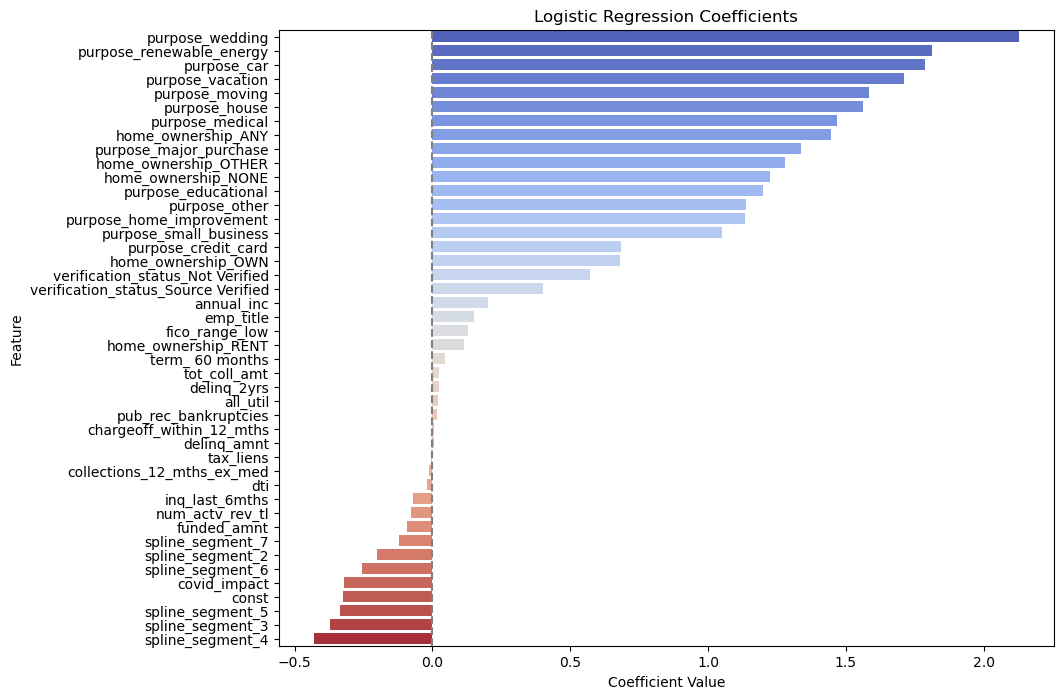

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns

# 회귀계수 추출
coefficients = best_model.coef_[0]
feature_names = X.columns

# 계수를 데이터프레임으로 변환
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# 계수의 절대값에 따라 정렬
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# 회귀계수 플롯 생성
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='coolwarm')

# 플롯 설정
plt.title('Logistic Regression Coefficients')
plt.axvline(x=0, color='grey', linestyle='--')  # 기준선 추가
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')

plt.show()


In [143]:
original_val['total_pymnt']

807049     10159.197571
4515        9580.350000
288412      6946.060000
1009239     6975.550000
389071     10933.051575
               ...     
344449     42822.228124
119518     10434.090529
568626      3872.280000
326229      7351.233019
392411     16537.950000
Name: total_pymnt, Length: 107607, dtype: float64

In [145]:
sum(original_val['total_pymnt'] - original_val['funded_amnt'])

69746719.51874596

In [146]:
78337201.37617296-69746719.51874596

8590481.857427001

우선 사용할 데이터프레임은 이미 전체의 40%가 분할이 되어있던 df_test이고
위의 코드에서 raw_train이었던게 이제 raw가 되고 (df_test의 스케일링 전 원본에 해당)
여기서도 위의 코드의 형식을 이어받아서 성능이 어떤지 test해주면 돼

In [148]:
import numpy as np
from sklearn.metrics import classification_report

# 종속 변수 y_test 설정 (0 이하인 경우 0, 0 초과인 경우 1로 변환)
y_test = (df_test['target'] > 0).astype(int)

# 독립 변수 설정 및 상수항 추가
X_test = df_test.drop(columns=['total_pymnt', 'irr', 'target'])
X_test = sm.add_constant(X_test)

# Test Set에 대해 원본 데이터를 인덱스를 통해 분할
test_idx = X_test.index
original_test = raw.loc[test_idx]  # raw 데이터의 원본에서 분할

# 최적의 모델을 사용하여 Test Set에 대한 예측 확률 계산
y_test_pred_probs = best_model.predict_proba(X_test)[:, 1]

# 최적의 임계값을 사용하여 Test Set의 예측 클래스 계산
y_test_pred_class = (y_test_pred_probs > best_threshold).astype(int)

# 수익 계산 함수 - validation에서 사용한 동일한 함수 사용
def profit_metric(y_true, y_pred, original):
    # 수익 계산: total_pymnt - funded_amnt
    profit_values = original.loc[y_true.index, 'total_pymnt'] - original.loc[y_true.index, 'funded_amnt']
    # 총 수익: 대출이 승인된 경우 (y_pred == 1)에서만 수익을 더함
    total_profit = np.sum(profit_values[y_pred == 1])
    return total_profit

# Test Set에 대해 수익 계산
test_profit = profit_metric(y_test, y_test_pred_class, original_test)

# 성능 평가 출력
print("\nConfusion Matrix:")
print(classification_report(y_test, y_test_pred_class))
print(f"Maximum Profit on Test Set: {test_profit}")



Confusion Matrix:
              precision    recall  f1-score   support

           0       0.33      0.30      0.31    128185
           1       0.85      0.87      0.86    594555

    accuracy                           0.77    722740
   macro avg       0.59      0.58      0.59    722740
weighted avg       0.76      0.77      0.76    722740

Maximum Profit on Test Set: 474144837.5243046


In [150]:
sum(original_test['total_pymnt'] - original_test['funded_amnt'])

463041065.62414837

In [151]:
474144837.5243046-463041065.62414837

11103771.90015626

In [152]:
# Confusion Matrix 분류에 따른 데이터프레임 분할
tp_idx = y_test[(y_test == 1) & (y_test_pred_class == 1)].index
tn_idx = y_test[(y_test == 0) & (y_test_pred_class == 0)].index
fp_idx = y_test[(y_test == 0) & (y_test_pred_class == 1)].index
fn_idx = y_test[(y_test == 1) & (y_test_pred_class == 0)].index

# 각각의 분류에 해당하는 original_test 데이터 추출
tp_values = original_test.loc[tp_idx, 'total_pymnt'] - original_test.loc[tp_idx, 'funded_amnt']
tn_values = original_test.loc[tn_idx, 'total_pymnt'] - original_test.loc[tn_idx, 'funded_amnt']
fp_values = original_test.loc[fp_idx, 'total_pymnt'] - original_test.loc[fp_idx, 'funded_amnt']
fn_values = original_test.loc[fn_idx, 'total_pymnt'] - original_test.loc[fn_idx, 'funded_amnt']

# 각 셀에서의 총 수익 계산
tp_profit = np.sum(tp_values)  # True Positives 수익
tn_profit = np.sum(tn_values)  # True Negatives 수익 (일반적으로 0이 될 가능성 높음)
fp_profit = np.sum(fp_values)  # False Positives 수익 (일반적으로 손실 발생 가능)
fn_profit = np.sum(fn_values)  # False Negatives 수익 (기회 손실)

# 각 수익 출력
print(f"True Positive Profit: {tp_profit}")
print(f"True Negative Profit: {tn_profit}")
print(f"False Positive Profit: {fp_profit}")
print(f"False Negative Profit: {fn_profit}")


True Positive Profit: 1116056499.5308466
True Negative Profit: -345557575.24611425
False Positive Profit: -641911662.0065418
False Negative Profit: 334453803.3459547


In [153]:
1116056499.5308466-345557575.24611425-641911662.0065418+334453803.3459547

463041065.6241452

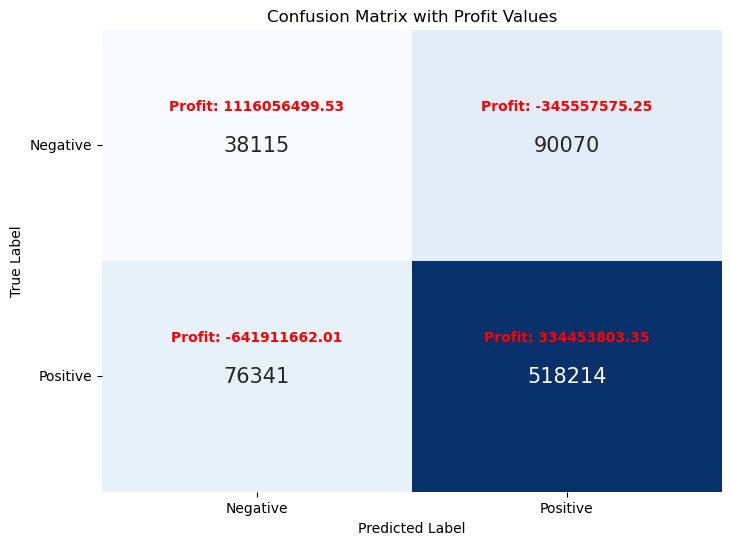

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion Matrix 계산
cm = confusion_matrix(y_test, y_test_pred_class)

# Confusion Matrix 셀의 수익 계산
profit_values = {
    'TP': tp_profit,
    'TN': tn_profit,
    'FP': fp_profit,
    'FN': fn_profit
}

# Confusion Matrix 플롯
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 15})

# 셀에 수익 값을 추가 (셀의 하단에 위치시키기)
for i, (text, profit) in enumerate(zip(['TN', 'FP', 'FN', 'TP'], profit_values.values())):
    # 행과 열 위치를 i로 계산 (00, 01, 10, 11 형태로 매칭)
    row = i // 2
    col = i % 2
    ax.text(col + 0.5, row + 0.3, f'Profit: {profit:.2f}', 
            ha='center', va='top', color='red', fontsize=10, fontweight='bold')

# Confusion Matrix 레이블 설정
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix with Profit Values')
plt.xticks([0.5, 1.5], ['Negative', 'Positive'], rotation=0)
plt.yticks([0.5, 1.5], ['Negative', 'Positive'], rotation=0)

plt.show()
